In [1]:
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn

from Encoder import Encoder, reparameterize
from Generator import Generator
from Discriminator import BigJointDiscriminator

from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor, Compose, Resize, Normalize

from tqdm.notebook import tqdm
import seaborn as sns

In [2]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
class InvertiblePriorLinear(nn.Module):
    def __init__(self):
        super(InvertiblePriorLinear, self).__init__()
        self.p = nn.Parameter(torch.rand([2]))
        
    def forward(self, eps):
        o = self.p[0] * eps + self.p[1]
        #o = torch.sigmoid(o)
        return o
    def inverse(self, o):
        #o = torch.log(o/(1-o))
        eps = (o - self.p[1])/self.p[0]
        return eps

class InvertiblePriorInv(nn.Module):
    """docstring for InvertiblePrior"""
    def __init__(self,prior):
        super(InvertiblePriorInv, self).__init__()
        self.prior = prior
    def forward(self, o):
        return self.prior.inverse(o)
    def inverse(self, eps):
        return self.prior(eps)


class SCM(nn.Module):
    def __init__(self, d, A=None, scm_type='mlp'):
        super().__init__()
        self.d = d
        self.A_given = A
        self.A_fix_idx = A == 0
        self.A = nn.Parameter(torch.zeros(d, d))

        prior_net_model = lambda : InvertiblePriorLinear()
        prior_net_enc_model = lambda x: InvertiblePriorInv(x)
        
        for i in range(d):
            setattr(self, "prior_net%d" % i, prior_net_model())
            setattr(self, "enc_net%d" % i, prior_net_enc_model(getattr(self, "prior_net%d" % i)))

    def set_zero_grad(self):
        if self.A_given is None:
            pass
        else:
            for i in range(self.d):
                for j in range(self.d):
                    if self.A_fix_idx[i, j]:
                        self.A.grad.data[i, j].zero_()

    def prior_nlr(self, z):
        '''Nonlinear transformation f_2(z)'''
        zs = torch.split(z, 1, dim=1)
        z_new = []
        for i in range(self.d):
            z_new.append(getattr(self, "prior_net%d" % i)(zs[i]))
        return torch.cat(z_new, dim=1)

    def enc_nlr(self, z):
        '''f_2^{-1}(z)'''
        zs = torch.split(z, 1, dim=1)
        z_new = []
        for i in range(self.d):
            z_new.append(getattr(self, "enc_net%d" % i)(zs[i]))
        return torch.cat(z_new, dim=1)

    def mask(self, z): # Az
        z = torch.matmul(z, self.A)
        return z

    def inv_cal(self, eps): # (I-A)^{-1}*eps
        adj_normalized = torch.inverse(torch.eye(self.A.shape[0], device=self.A.device) - self.A)
        z_pre = torch.matmul(eps, adj_normalized)
        return z_pre

    def get_eps(self, z):
        '''Returns epsilon from f_2^{-1}(z)'''
        return torch.matmul(z, torch.eye(self.A.shape[0], device=self.A.device) - self.A)

    def intervene(self, z, z_ori):
        # f_2^{-1}(z)
        z_ori = self.enc_nlr(z_ori)
        z = self.enc_nlr(z)
        # masked nonlinear z
        z_new = self.mask(z)
        z_new = z_new + self.get_eps(z_ori)
        return self.prior_nlr(z_new)

    def forward(self, eps=None, z=None):
        if eps is not None and z is None:
            # (I-A.t)^{-1}*eps
            z = self.inv_cal(eps) # n x d
            # nonlinear transform
            return self.prior_nlr(z)
        else:
            # f_2^{-1}(z)
            z = self.enc_nlr(z)
            # mask z
            z_new = self.mask(z) # new f_2^{-1}(z) (without noise)
            return z_new, z

In [4]:
class ImageDataset(Dataset):
    def __init__(self,root_folder,transform, cols = None):
        self.transform=transform
        self.img_folder=root_folder+'img/img_align_celeba/'

        self.image_names=[i for i in os.listdir(self.img_folder) if '.jpg' in i]
        self.attr = pd.read_csv(root_folder+'attr.csv').replace(-1,0)
        _ = self.attr.pop('image_id')
        if cols is not None:
            self.attr = self.attr[cols]    
        self.num_feat = len(self.attr.columns)
        self.order = list(self.attr.columns)
        
        self.attr = self.attr.values
   
    def __len__(self):
        return len(self.image_names)
 
    def __getitem__(self, index):
        image_path = self.img_folder + self.image_names[index]
        image=Image.open(image_path)
        image=self.transform(image)
        label = torch.tensor(self.attr[index], dtype = torch.float)

        return image, label

def get_train_dataloader(root_folder, img_dim=64, batch_size=32, cols = None):

    transform = Compose([Resize((img_dim, img_dim)),
                        ToTensor(),
                        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    training_data = ImageDataset(root_folder='dataset/celebA/',transform=transform, cols = cols)
    train_dataloader = DataLoader(training_data, batch_size = batch_size, shuffle = True)
    return train_dataloader

In [5]:
cols = ['Smiling', 'Male', 'High_Cheekbones', 'Mouth_Slightly_Open', 'Narrow_Eyes', 'Chubby']

In [6]:
root_folder = 'sample_data/'

in_channels = 3
fc_size = 2048
latent_dim = 100

img_dim = 64
batch_size = 128

num_label = len(cols)

In [7]:
train_dataloader = get_train_dataloader(root_folder, img_dim=img_dim, batch_size=batch_size, cols = cols)

In [8]:
A = torch.zeros((num_label, num_label), device = device)
A[0, 2:6] = 1
A[1, 4] = 1

In [9]:
prior = SCM(num_label, A, scm_type='linscm').to(device)
prior_param = list(prior.parameters())

In [10]:
e = Encoder(latent_dim = latent_dim, fc_size = fc_size).to(device)
g = Generator(latent_dim = latent_dim, image_size = img_dim).to(device)
disc = BigJointDiscriminator(latent_dim = latent_dim, image_size = img_dim).to(device)

In [11]:
A_optimizer = optim.Adam(prior_param[0:1], lr=5e-4)
p_optimizer = optim.Adam(prior_param[1:],  lr=5e-4, betas=(0, 0.999))

In [12]:
e_optimizer = optim.Adam(e.parameters(), lr=5e-5, betas=(0, 0.999))
g_optimizer = optim.Adam(g.parameters(), lr=5e-5, betas=(0, 0.999))
d_optimizer = optim.Adam(disc.parameters(), lr=1e-4, betas=(0, 0.999))

In [13]:
num = len(train_dataloader.dataset)//batch_size

epochs = 10

In [14]:
disc_steps = 1
g_steps = 1
e_steps = 1

celoss = torch.nn.BCEWithLogitsLoss()

In [15]:
def plot_image(fake):
    with torch.no_grad():
        fake = np.transpose(fake.cpu().numpy(), (0, 2, 3, 1))
    _,ax = plt.subplots(1, 10, figsize=(24,4))
    for i in range(10):
        ax[i].imshow(fake[i])
    plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1582 [00:00<?, ?it/s]

[1/10] Encoder Loss : 2.74960 Gen Loss : -0.02263 Disc Loss : 1.29268


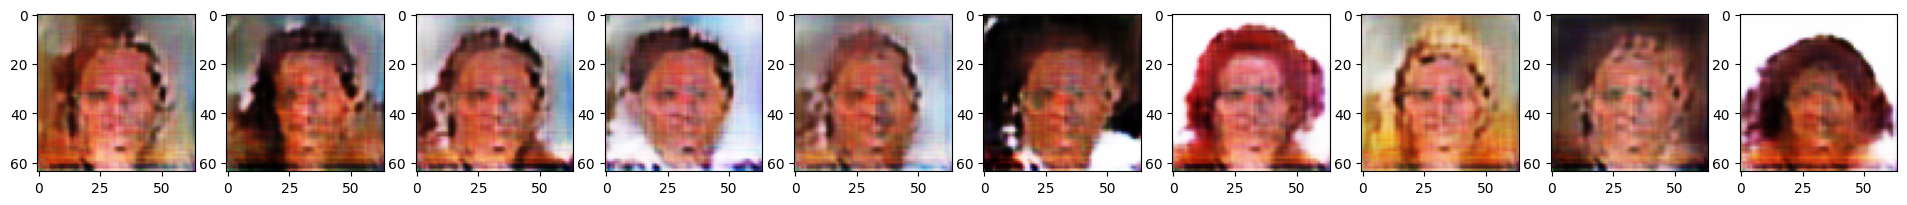

tensor([[ 6.4463,  0.3084,  1.7763,  1.8216,  5.9670, -2.8608],
        [ 7.1318, -0.7906,  2.0467,  1.3170,  0.2395, -4.2709],
        [ 4.5194, -0.2365,  2.1782,  2.4489,  1.7075, -3.6160],
        [ 6.7092,  0.1018,  2.1781,  2.0930,  0.5072, -2.3068],
        [ 6.2775, -0.4620,  2.4376,  2.4986, -2.7923, -1.7901],
        [ 6.2753, -0.3027,  2.1863,  2.0553,  1.2654, -1.4770],
        [ 5.7278, -0.5576,  2.1118,  1.9833, -2.2396, -1.3757],
        [ 6.1789, -0.3199,  2.0057,  1.1181, -0.3124, -2.7323],
        [ 2.5342, -0.1909,  2.1145,  0.7312, -3.3893, -5.9450],
        [ 1.8884,  0.3215,  2.1507,  2.1480, -2.8882, -0.7155]],
       device='cuda:0') 
 tensor([[0., 0., 1., 0., 0., 0.],
        [1., 0., 1., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 0., 1., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0.],
        [1., 0., 1., 1., 1., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0.

  0%|          | 0/1582 [00:00<?, ?it/s]

[2/10] Encoder Loss : 2.21155 Gen Loss : -0.00597 Disc Loss : 1.34694


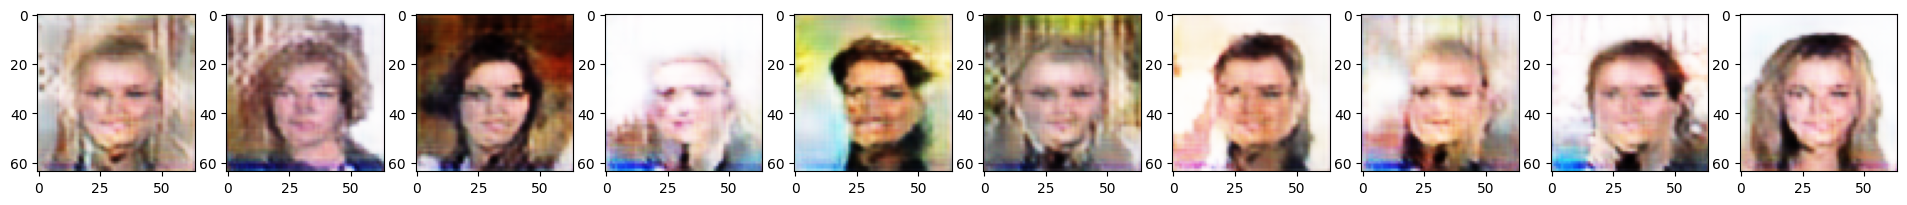

tensor([[11.4162,  0.2917,  2.0193,  1.9088, -2.6562, -3.9132],
        [-5.3033, -1.8172,  2.0340,  1.8142,  2.3718, -7.4779],
        [ 5.9361, -1.3331,  2.0155,  1.7722, -6.9483,  1.6483],
        [14.9049,  0.2042,  2.1916,  1.8495,  3.8013, -9.3797],
        [ 6.7856, -0.3041,  2.1005,  1.9707, -2.4561, -5.6005],
        [10.3762, -1.8686,  2.0726,  1.7276, -4.7238, -3.4296],
        [ 8.6600,  0.4656,  1.7019,  2.0558, -1.5422, -3.6248],
        [12.7578, -2.1444,  1.8562,  1.9880, -4.6240, -4.9900],
        [ 7.6642, -1.3108,  1.9867,  2.1561, -3.3990, -6.6269],
        [ 7.4648, -0.8078,  1.8217,  1.7572, -2.6071, -3.3830]],
       device='cuda:0') 
 tensor([[0., 1., 0., 0., 0., 0.],
        [1., 0., 1., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 0., 1., 1., 0., 0.],
        [1., 0., 1., 0., 0.

  0%|          | 0/1582 [00:00<?, ?it/s]

[3/10] Encoder Loss : 2.13384 Gen Loss : 0.02015 Disc Loss : 1.34151


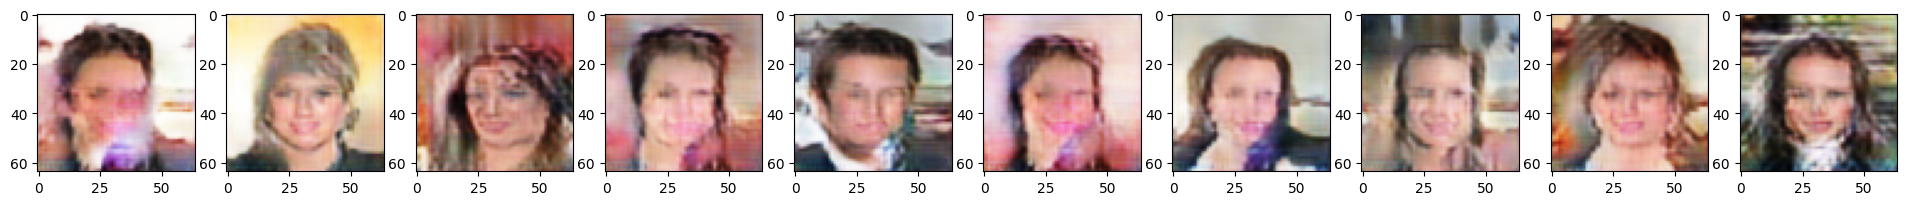

tensor([[ 17.9963,  -0.0684,   2.0393,   1.7196,   3.5682,  -6.9420],
        [  5.7675,  -0.1175,   1.9106,   1.6474,  -5.9332,  -3.9135],
        [  0.4442,  -0.8869,   2.0099,   1.3179, -14.7791,  -6.7167],
        [ 16.1491,   1.6793,   1.9345,   1.1459,  -6.4109,  -8.8642],
        [ 11.7103,  -2.3315,   2.0772,   1.5484,  -5.1814,  -7.9986],
        [ 18.8824,  -2.9048,   1.9610,   1.4389,  -8.2970,  -8.9844],
        [ 12.6041,  -2.9412,   1.9690,   1.4784,  -0.1693, -11.2989],
        [ 12.9784,  -2.0570,   2.1481,   1.7968,  -5.0294,  -9.3993],
        [ 14.3066,  -0.8600,   2.0878,   1.8411,  -2.8878,  -1.9933],
        [  5.5250,  -2.5451,   1.8411,   1.8443,   4.6976,  -5.5597]],
       device='cuda:0') 
 tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0., 1.],
        [1., 1., 1., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [1., 1., 0., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0.],
 

  0%|          | 0/1582 [00:00<?, ?it/s]

[4/10] Encoder Loss : 2.16789 Gen Loss : 0.03726 Disc Loss : 1.31025


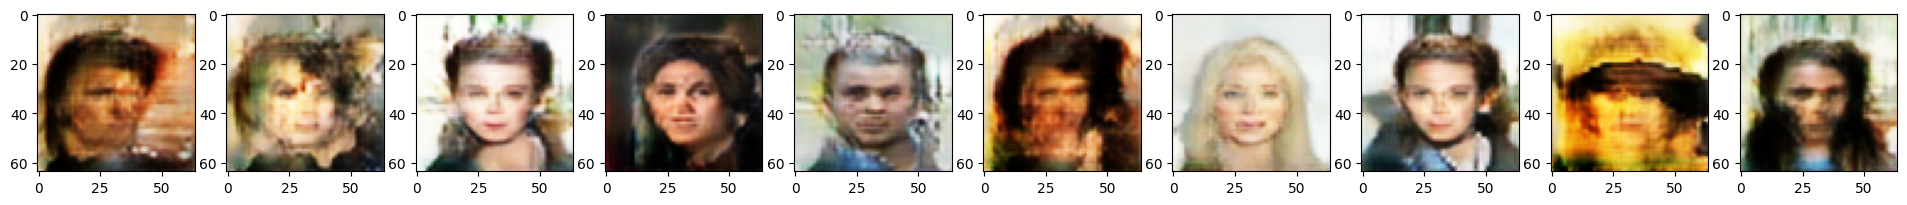

tensor([[ 23.7000,  -2.3840,   1.8738,   1.9579,  -0.0826,  -8.0705],
        [ 21.9417,   2.3594,   2.2244,   2.0624, -18.8900,  -2.5112],
        [ 12.3648,  -2.6659,   2.0100,   1.9454,   4.1435,  -8.0311],
        [ 10.4550,  -3.9076,   2.0638,   1.9603,  -5.9732,   3.3713],
        [ 13.2741,   1.4894,   1.9929,   1.9753,  -9.3719, -10.0511],
        [ 33.1438,  -3.0946,   2.3475,   2.1579, -11.8201, -11.4185],
        [  0.7113,  -1.8062,   1.9560,   1.8838,  -0.4147,  -7.5054],
        [ 12.2543,  -0.7259,   2.1240,   1.7480,   1.8989,  -5.6886],
        [  0.9983,  -2.2111,   1.8958,   2.2986, -26.6300,  -5.3403],
        [ 22.4398,  -0.3268,   2.4400,   1.9703,  -4.5258,  -9.3331]],
       device='cuda:0') 
 tensor([[1., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0.],
        [1., 0., 1., 1., 1., 0.],
        [1., 1., 0., 1., 0., 1.],
        [1., 0., 1., 1., 0., 0.],
        [1., 0., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
 

  0%|          | 0/1582 [00:00<?, ?it/s]

[5/10] Encoder Loss : 2.17909 Gen Loss : 0.04289 Disc Loss : 1.28724


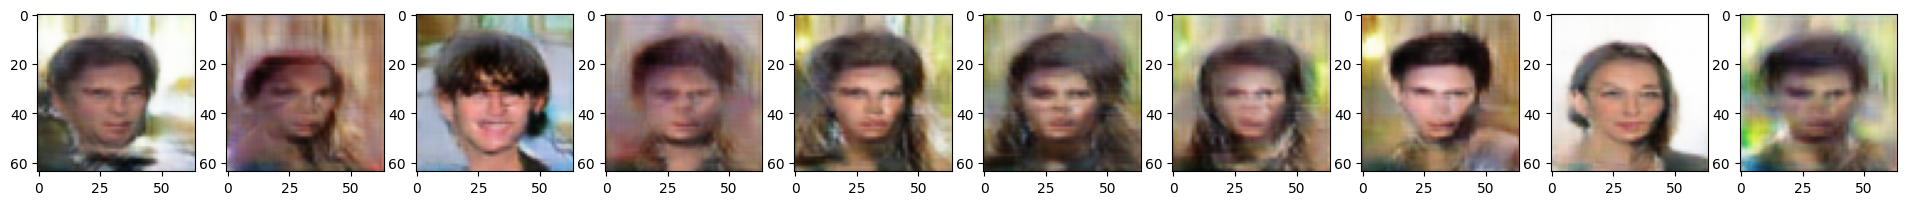

tensor([[ 19.8029,  -2.5702,   2.5293,   1.7907, -10.8608,  -2.8394],
        [ 19.9492,   1.9638,   2.2332,   2.2474,  -1.8692, -10.3935],
        [  4.7587,  -1.2647,   2.2938,   1.6622, -18.5063,  -3.6023],
        [ 28.7444,  -8.1002,   2.4429,   2.3807, -17.2992,  -6.1120],
        [ 22.4736,  -4.1873,   2.2844,   2.2698,  -3.2831,  -7.1520],
        [ 22.9238,  -4.2063,   2.8674,   2.2165,  -7.6621, -10.9361],
        [ 32.0324,  -3.0936,   2.3591,   1.9719,  -5.0712,  -2.0639],
        [ 23.1518,  -3.1913,   2.1454,   2.2109,   4.9786,   2.8346],
        [  7.8339,  -1.1362,   2.1921,   2.0160,   3.1239,  -6.5262],
        [ 23.3190,   2.3363,   2.1442,   2.0201,   5.2532, -11.8647]],
       device='cuda:0') 
 tensor([[1., 1., 1., 1., 0., 0.],
        [1., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0.],
        [1., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
 

  0%|          | 0/1582 [00:00<?, ?it/s]

[6/10] Encoder Loss : 2.10295 Gen Loss : 0.05990 Disc Loss : 1.27185


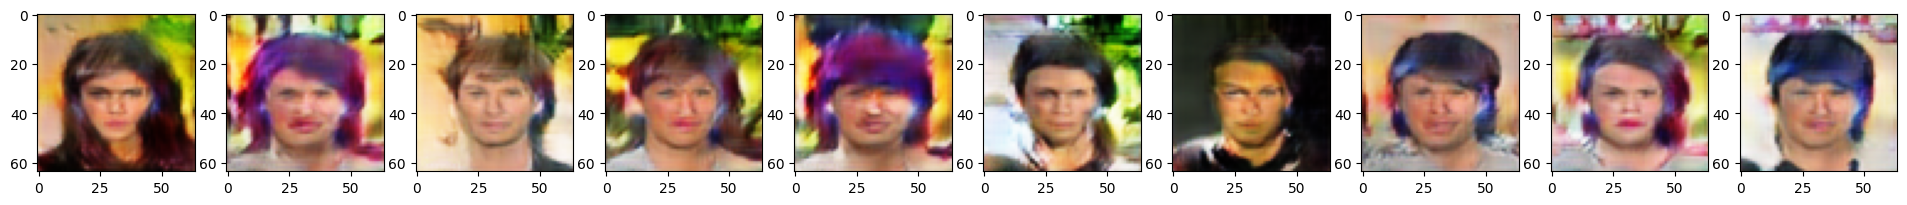

tensor([[ 13.9155,   1.1706,   3.9369,   2.5405,   6.1893, -11.7398],
        [ 28.4000,  -4.0939,   3.5248,   2.4851, -23.8725,  -4.0954],
        [ 14.9646,  -1.2442,   3.2828,   1.8170, -12.3947,  -8.3509],
        [ 20.5196,  -6.4923,   4.1054,   2.5468, -17.4307, -10.1881],
        [ 25.0090,  -1.7352,   4.8754,   1.2224, -27.4715,  -7.6586],
        [ 22.9908,   0.1444,   1.8166,   2.3921,  -0.7099, -11.0708],
        [ 12.5550,   2.8870,   2.2372,   2.1758,   0.0845,  -3.9983],
        [ 26.8130,  -3.6284,   3.5334,   1.9765, -30.1646,  -9.4473],
        [ 24.9278,   2.4750,   4.2911,   2.2308, -12.3798,  -3.2825],
        [ 23.2064,   0.4154,   2.3567,   3.2413, -19.7685, -11.6095]],
       device='cuda:0') 
 tensor([[1., 0., 1., 1., 0., 0.],
        [1., 0., 1., 1., 0., 0.],
        [0., 0., 1., 0., 1., 0.],
        [1., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [1., 1., 0., 1., 0., 0.],
        [1., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
 

  0%|          | 0/1582 [00:00<?, ?it/s]

[7/10] Encoder Loss : 1.93132 Gen Loss : 0.08192 Disc Loss : 1.24900


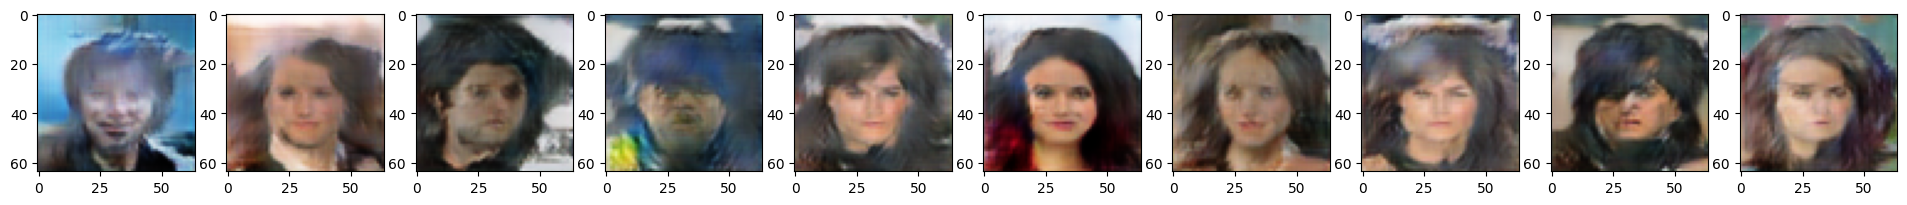

tensor([[  1.0367,  -4.8760,   5.9950,   2.9266,  -4.0658, -13.4604],
        [ 19.2397,  -8.1032,   7.1061,   0.8303, -29.2611, -10.1036],
        [ 22.7638,   2.7608,   2.4145,   1.0811,  -7.1183,  -6.1521],
        [ 21.4636,   7.7010,   1.4304,   2.9278,  -1.9159, -24.1986],
        [ 25.2812,   1.2412,  10.5926,   2.6516,  -2.7772, -13.9271],
        [ 21.9369,  -6.7503,   1.9459,   3.2425, -18.1989,  -3.5324],
        [ 14.7386,  -4.5676,   4.0179,   2.7681, -19.3641, -12.4629],
        [ 24.4125,   4.7689,   2.0422,   5.6189,  -3.9439, -10.5453],
        [ 25.9548,   0.2618,   4.4964,   3.8831,  -0.8155, -18.2149],
        [ 27.6007,   8.7055,   2.8373,   2.8655, -16.4993,  -4.5817]],
       device='cuda:0') 
 tensor([[0., 1., 0., 1., 0., 0.],
        [1., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [0., 1., 0., 0., 1., 0.],
        [1., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
 

  0%|          | 0/1582 [00:00<?, ?it/s]

[8/10] Encoder Loss : 1.65978 Gen Loss : 0.09229 Disc Loss : 1.23430


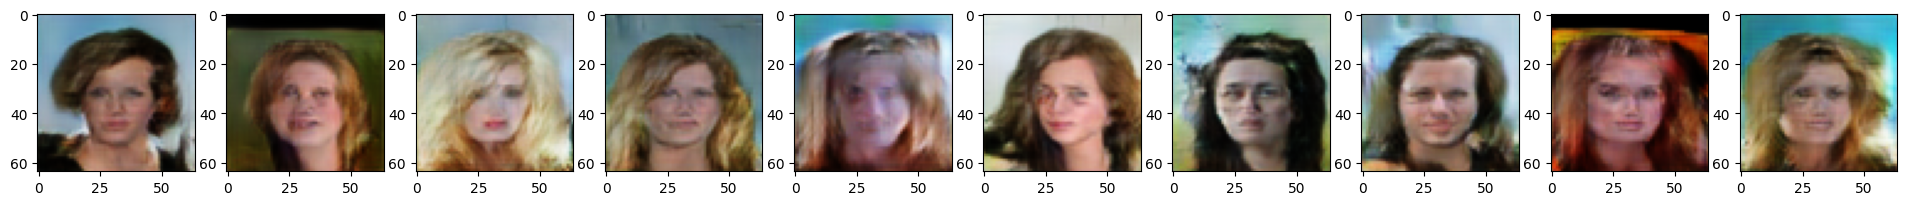

tensor([[ 20.1292,   1.1429,  -1.3899,   0.1158, -19.6249, -13.7364],
        [  9.4942,   0.6555,   0.9274,   3.7328, -12.6864, -16.4705],
        [ 20.1686, -10.5861,  -1.3346,   4.0338, -13.0962, -21.3372],
        [ 21.3721,  11.8772,   1.9145,  -3.2464, -14.6119, -19.5950],
        [ 19.4981,   1.0871,   7.0418,   4.6121, -19.4905, -22.3213],
        [ 25.8467,  -0.7979,  -7.4326,  -3.9168,  -9.3274,  -5.8123],
        [ 16.9858,  -3.0838,   8.6345,   7.7677,  -6.1953,   1.7040],
        [ 16.7891,  -0.2933,   3.4986,   3.5988, -17.1753, -22.7602],
        [ 19.7308,   7.8425,   4.3260,  -4.2638, -17.2777,  -9.3342],
        [ 21.4651,   3.9068,   7.2588,  -1.6195, -15.3430, -18.3206]],
       device='cuda:0') 
 tensor([[0., 1., 1., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
 

  0%|          | 0/1582 [00:00<?, ?it/s]

[9/10] Encoder Loss : 1.41318 Gen Loss : 0.12467 Disc Loss : 1.20793


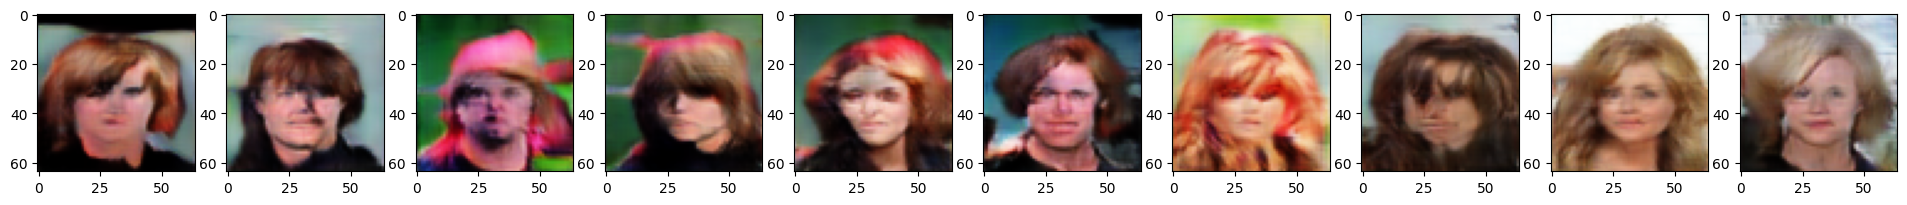

tensor([[ 17.9222,  -7.4514,   9.8218,   8.3079, -15.0822, -42.4784],
        [  9.8100, -12.5894,  29.9855,  12.8328,  14.9527, -17.4235],
        [ 23.5873,  23.8815,  -3.2428,  -7.0395,  -4.2677,  -4.6815],
        [ 16.7623,  10.0316,   9.4802,  11.7468,  -0.1431, -12.1513],
        [ 25.5132,  13.3679,   3.5530,  -2.6616, -26.7136, -15.2488],
        [ 27.0344,   2.4264,   4.3252, -12.0713, -31.9795, -18.4597],
        [ 19.1271, -19.0485,   9.6074,  12.5861,   3.4499, -17.3594],
        [ 14.3167, -23.0653,  15.0044,  13.2848, -10.5172, -18.0520],
        [ 22.4574, -10.2168,   1.5607, -10.6613,   5.5296,  -5.6438],
        [ 29.3909, -18.9018, -10.7246,  -0.8567, -12.8271, -17.2127]],
       device='cuda:0') 
 tensor([[1., 0., 1., 1., 0., 0.],
        [1., 0., 1., 1., 1., 0.],
        [0., 0., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0.],
        [1., 0., 1., 1., 0., 0.],
 

  0%|          | 0/1582 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [16]:
for epoch in tqdm(range(epochs)):
    disc_loss, e_loss, g_loss = [], [], []
    
    e.train()
    g.train()
    disc.train()
    prior.train()
    with torch.autograd.set_detect_anomaly(True):
        for (X, label) in tqdm(train_dataloader, total = num):        
            X = X.to(device)

            sup_flag = label[:, 0] != 0
            if sup_flag.sum() > 0:
                label = label[sup_flag, :].float()
            label = label.to(device)

            for _ in range(disc_steps):
                disc.zero_grad()

                z = torch.randn(X.shape[0], latent_dim, device=device)

                mu, sigma = e(X)
                z_fake = reparameterize(mu, sigma )

                label_z = prior(z[:, :num_label])
                other_z = z[:, num_label:]
                z = torch.cat([label_z, other_z], dim=1)

                X_fake = g(z)

                e_score = disc(X, z_fake.detach())
                g_score = disc(X_fake.detach(), z.detach())

                del z_fake
                del X_fake

                loss_d = F.softplus(g_score).mean() + F.softplus(-e_score).mean()
                loss_d.backward()
                d_optimizer.step()
                disc_loss.append(loss_d.item())

            #___________________________________
            for _ in range(e_steps):
                g.zero_grad()
                e.zero_grad()
                prior.zero_grad()    
                mu, sigma = e(X)
                z_fake = reparameterize(mu, sigma )

                e_score = disc(X, z_fake)
                l_encoder = e_score.mean()
                sup_loss = None
                if sup_flag.sum() > 0:
                    label_z = mu[sup_flag, :num_label]
                    sup_loss = celoss(label_z, label)
                else:
                    sup_loss = torch.zeros([1], device=device)
            
                l_encoder = l_encoder + sup_loss * 5
                l_encoder.backward()

                e_loss.append(l_encoder.item())
                e_optimizer.step()
                p_optimizer.step()
                
                ## Generator 
                z = torch.randn(X.size(0), latent_dim, device=device, requires_grad = False)            
                label_z = prior(z[:, :num_label])
                other_z = z[:, num_label:]
                z = torch.cat([label_z, other_z], dim=1)

                X_fake = g(z)
                g_score = disc(X_fake, z)
                s_decoder = torch.exp(g_score.detach()).clamp(0.5, 2)
                loss_decoder = -(s_decoder * g_score).mean()
                g_loss.append(loss_decoder.item())
                loss_decoder.backward()
                g_optimizer.step()

                prior.set_zero_grad()
                A_optimizer.step()
                p_optimizer.step()
        
        print(f"[{epoch+1}/{epochs}] Encoder Loss : {sum(e_loss)/num:>.5f} Gen Loss : {sum(g_loss)/num:>.5f} Disc Loss : {sum(disc_loss)/num:>.5f}")
        
        if epoch % 1 == 0:
            with torch.no_grad():
                e.eval()
                g.eval()
                prior.eval()
                for X, label in train_dataloader:
                    mu, sigma = e(X.to(device))
                    z = reparameterize(mu, sigma)
                    label_z = prior(z[:, :num_label])
                    other_z = z[:, num_label:]
                    z = torch.cat([label_z, other_z], dim=1)
                    x_fake = g(z)
                    x_fake = (x_fake * 0.5) + 0.5
                    plot_image(x_fake)
                    print(z[:10,:num_label],'\n', label[:10])
                    break

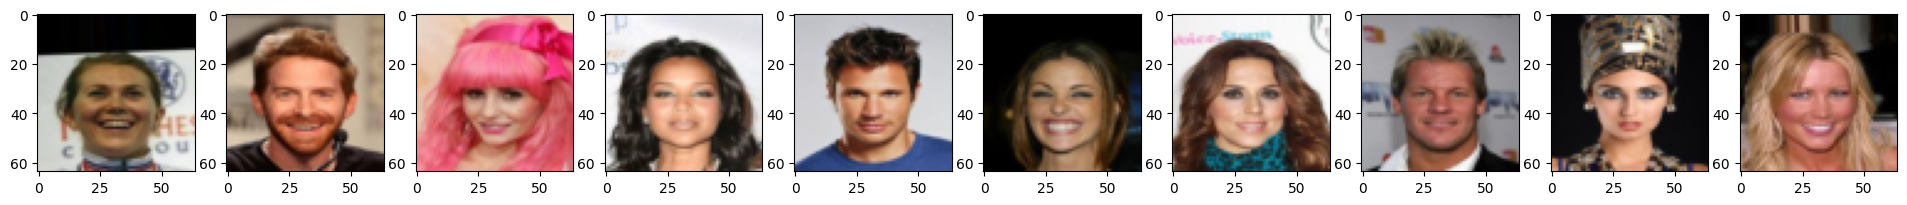

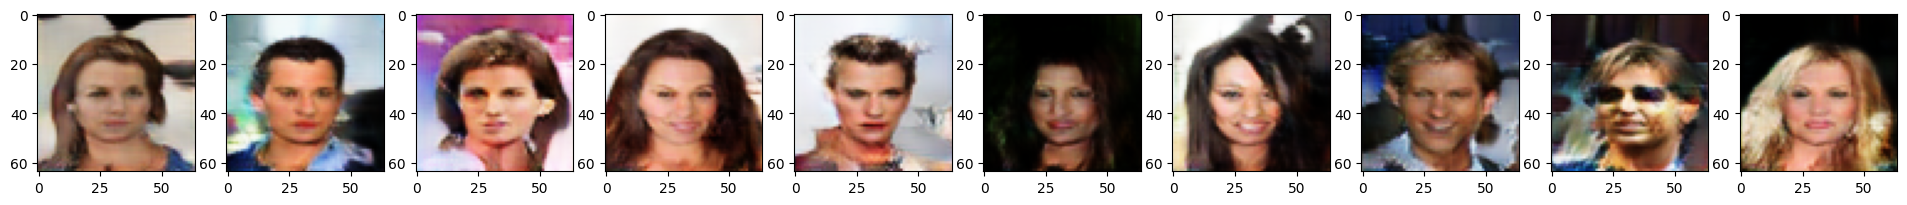

tensor([[1.0000e+00, 9.9322e-01, 1.0000e+00, 1.0000e+00, 6.4488e-05, 8.5266e-12],
        [1.0000e+00, 2.4921e-08, 1.0000e+00, 8.4782e-01, 5.8886e-05, 2.0925e-07],
        [1.0000e+00, 1.0000e+00, 9.6569e-01, 9.5293e-01, 3.8069e-11, 3.3871e-11],
        [1.0000e+00, 4.1804e-01, 1.0000e+00, 9.9999e-01, 7.4458e-07, 3.1738e-08],
        [1.0000e+00, 1.7379e-07, 9.9764e-01, 2.2495e-01, 4.4861e-09, 2.0939e-04],
        [1.0000e+00, 8.5304e-01, 9.9873e-01, 3.9253e-03, 3.8048e-02, 2.7832e-06],
        [1.0000e+00, 3.6958e-04, 1.0000e+00, 1.0667e-02, 6.5361e-01, 1.0000e+00],
        [1.0000e+00, 9.1640e-01, 1.6774e-03, 2.6155e-01, 3.9289e-09, 2.3606e-09],
        [1.0000e+00, 6.2292e-02, 1.0000e+00, 6.4648e-05, 1.3996e-06, 1.7162e-11],
        [1.0000e+00, 9.9318e-01, 1.8226e-01, 9.7532e-01, 2.8199e-09, 1.4264e-13]],
       device='cuda:0', grad_fn=<SigmoidBackward0>) tensor([[0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 0., 1., 1., 

In [17]:
for X, label in train_dataloader:
    mu, sigma = e(X.to(device))
    z = reparameterize(mu, sigma)
    label_z = prior(z[:, :num_label])
    other_z = z[:, num_label:]
    z = torch.cat([label_z, other_z], dim=1)
    x_fake = g(z)
    x_fake = (x_fake * 0.5) + 0.5
    plot_image((X * 0.5) + 0.5)
    plot_image(x_fake)
    print(torch.sigmoid(z[:10,:num_label]), label[:10])
    break

In [ ]:
print(A)
print(prior.A.data.to(device='cpu'))

In [ ]:
sns.heatmap(prior.A.data.to(device='cpu'),
            cmap="crest",
            square='True', 
            xticklabels = cols, 
            yticklabels = cols)

In [23]:
torch.save({
            'epoch': 9,
            'model_state_dict': e.state_dict(),
            'optimizer_state_dict': e_optimizer.state_dict(),
            },'model/e')
torch.save({
            'epoch': 9,
            'model_state_dict': g.state_dict(),
            'optimizer_state_dict': g_optimizer.state_dict(),
            },'model/g')
torch.save({
            'epoch': 9,
            'model_state_dict': disc.state_dict(),
            'optimizer_state_dict': d_optimizer.state_dict(),
            },'model/disc')

torch.save({
            'epoch': 9,
            'model_state_dict': prior.state_dict(),
            'optimizer_state_dict': p_optimizer.state_dict(),
            },'model/prior')